# Propension

Implementação em Python de estudo de Propensão de usuários

## Objetivo

Documentação de guia de Propensão de usuário à conversão: da extração do BQ à modelagem.

## Referências

* [DISCLAIMER] Helper Methods, obtidos em: https://github.com/YanSym/Data-Science-Projects/blob/master/Credit%20Card%20Fraud%20Detection.ipynb
* ColumnTransformer, Pipeline e Grid Search: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
* Get features from ColumnTransformer: https://github.com/scikit-learn/scikit-learn/issues/12525


## Setup

In [0]:
!apt-get update

!pip install pandas --upgrade # para funcionar o json para flat table
!pip install -U -q PyDrive
#!pip install matplotlib
#!pip install numpy
!pip install lightgbm
!pip install lime
!pip install --upgrade google-cloud-bigquery
!pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

In [0]:
import json
import gc # garbage collector
import numpy as np
import pandas as pd
import scipy.stats as stats
import pylab as pl
import pickle
import lime
import lime.lime_tabular
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from pandas.io.json import json_normalize
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import explained_variance_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score,accuracy_score, auc
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error, recall_score, precision_score, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer

## Autenticação Google Drive

In [0]:
#import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive 
drive.mount('/content/gdrive')



# Autentica e cria um cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print('Authenticated')

## Extração Query BQ

A biblioteca **google.cloud.bigquery** permite rodar a query e mostrar o resultado ou salvar em uma dataframe.

In [0]:
%%bigquery --project propension df
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`

,total_rows
0,903653


Declara o Cloud Project Id do BQ: https://console.cloud.google.com/bigquery?project=propension&page=savedqueries

In [0]:
project_id = 'propension'

Determina o tamanho do dataset do BQ

In [0]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 2000
row_count = client.query('''
  SELECT
    COUNT(*) as total
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`''').to_dataframe().total[0]

print('O dataset tem %d linhas' % row_count)

O dataset tem 903653 linhas


Uso do BQ com o pandas-gbq para fazer a query para o modelo de propensão. 
[Documentação do Pandas GBQ](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_gbq.html)

In [0]:
%%time
df = pd.io.gbq.read_gbq('''
  #standardSQL
  SELECT
      date,
      trafficSource.source AS source,
      trafficSource.source AS medium,
      fullVisitorId,
      channelGrouping,
      SUM(totals.pageviews) AS pageviews,
      SUM(totals.transactions) AS transactions,
      SUM(totals.timeOnSite) AS SUM_totals_timeOnSite,
      totals.totalTransactionRevenue AS receita,
      device.deviceCategory AS device,
      geoNetwork.country AS pais,
      MOD(ABS(FARM_FINGERPRINT(fullVisitorId)), 20) as farm_finger
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` #, UNNEST(hits) AS hits
  GROUP BY
      date,
      source,
      medium,
      fullVisitorId,
      channelGrouping,
      receita,
      device,
      pais
    
  ''', project_id=project_id, verbose=False, dialect='standard')

df.head()
df.tail(1)

CPU times: user 45 s, sys: 1.79 s, total: 46.7 s
Wall time: 1min 55s


Salva o dataframe da Query do BQ em um .csv

In [0]:
%%time
df.to_csv("input_hash.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile("input_hash.csv")
file.Upload()

## Importação Módulos Python no Colab

In [0]:
# Linka o Colab Notebook aos Modulos
HelperMethods = drive.CreateFile({'id':'1A4kJsVS1YCLmDalPLbqbNC4LKMCdkPwg'})

# Importa modulos Python no Colab
HelperMethods.GetContentFile('HelperMethods.py')

In [5]:
from HelperMethods import HelperClass

Using TensorFlow backend.


## Leitura entrada

In [0]:
%%time
#df = drive.CreateFile({'id': '1Qis6v-c-KQLsf_SaEpI4F8r7qRDycbyX'})
#df.GetContentFile('input_hash.csv')
#df = pd.read_csv("input_hash.csv", low_memory=False)
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/Propension/input_hash.csv')

CPU times: user 1.34 s, sys: 108 ms, total: 1.45 s
Wall time: 1.5 s


<string>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


## Análise exploratória da Base

### Tratamento Data

In [0]:
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    #df['weekday'] = df['date'].dt.weekday
    #df['day'] = df['date'].dt.day
    #df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year 
    #df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int) 
    return df

In [0]:
df = date_process(df)

###Preenche os NaN com zeros

Verifica se tem NaN

In [0]:
df.isnull().values.any()
df[df.isnull().T.any().T]

In [0]:
df['pageviews'] = df['pageviews'].fillna(0.0).astype(float)
df['receita'] = df['receita'].fillna(0.0).astype(float)
df['transactions'] = df['transactions'].fillna(0.0).astype(float)
df['SUM_totals_timeOnSite'] = df['SUM_totals_timeOnSite'].fillna(0.0).astype(float)
df['fullVisitorId'].values

array([6511711172391610103, 1124596635695894323, 5617857737551069038, ...,
       874728240053439901, 7684104685636271707, 1936898665278822233],
      dtype=object)

### Cria coluna alvo

In [0]:
df['target'] = np.where(df['receita'] > 0, 1, 0)
df.drop(['transactions', 'receita'], axis=1, inplace=True)
df.head(1)

,date,source,medium,fullVisitorId,channelGrouping,pageviews,SUM_totals_timeOnSite,device,pais,farm_finger,target
0,2017-04-12,google,google,6511711172391610103,(Other),5.0,379.0,mobile,United States,8,0


### Salva coluna FullvisitorID

In [0]:
df_id = df.filter(['fullVisitorId'], axis=1)
df.drop(['fullVisitorId'], axis=1, inplace=True)

###Análise colunas categóricas e numéricas

In [0]:
def uniqueCategoricalFeatures(df, tipo):
  """ Retorna a soma única da features do tipo 'tipo'.
  
  Args:
    df: dataframe com colunas do tipo 'tipo'
    tipo: o tipo da coluna a ser exibida
    
  Returns:
    Imprime a quantidade de ocorrências únicas do tipo 'tipo'
  """
  categorical_list = list(df.select_dtypes(include=[tipo]))
  for feature in categorical_list:
    print("Feature: %s - %s" % (feature, df[feature].nunique()))

Verificar a quantidade de tipos nas features categoricas. Ver se faz sentido criar muitas colunas dummies.

In [0]:
uniqueCategoricalFeatures(df, tipo='object')

Feature: source - 275
Feature: medium - 275
Feature: channelGrouping - 8
Feature: device - 3
Feature: pais - 222


In [0]:
def topArray(df, groupByColumn, sumColumn, n_values):
  """ Retorna os top n_values da coluna groupByColumn somados pelo sumColumn
  
  Args:
    df: dataframe com a coluna a ser agrupada
    groupByColumn (str): nome da coluna a ser agrupda
    sumColumn (str): nome da coluna a ser somada
    n_values: quantidade a ser mostrada
    
  Returns:
    * Uma lista (array) com os top n_values
    * Imprime o share que esses top n_values representam
    * Plota de colunas
  
  """
  top_df = df.groupby(groupByColumn).sum()
  top_df.sort_values(sumColumn, ascending=False, inplace=True)
  top_df = top_df.loc[:,[sumColumn]]
  top_df['share'] = top_df[sumColumn]*100/top_df[sumColumn].sum()
  top_df = top_df.nlargest(n_values,sumColumn)
  print(top_df['share'].sum())
  top_df['share'].plot.bar()
  return top_df.index.values

86.10611689175633
99.07582825302877
99.07582825302877


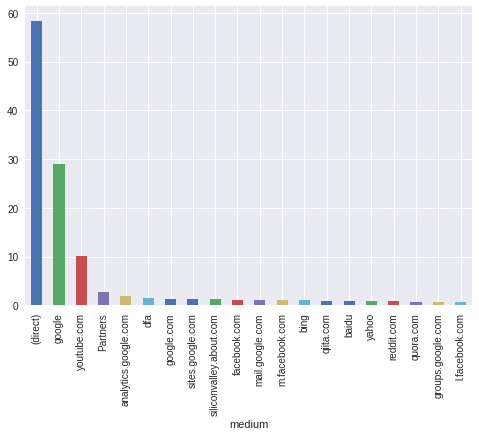

In [0]:
pais_array = topArray(df, 'pais', 'pageviews', 20)
source_array = topArray(df, 'source', 'pageviews', 20)
medium_array = topArray(df, 'medium', 'pageviews', 20)

df['pais_top'] = df['pais'].apply(lambda x: x if x in pais_array else "(Other)")
df['source_top'] = df['source'].apply(lambda x: x if x in source_array else "(Other)")
df['medium_top'] = df['medium'].apply(lambda x: x if x in medium_array else "(Other)")
df.drop(['pais', 'source', 'medium'], axis=1, inplace = True)

In [0]:
df_input = df.copy()
df_input.to_csv("df_input.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile("df_input.csv")
file.Upload()

In [0]:
df_input = pd.read_csv('gdrive/My Drive/Colab Notebooks/Propension/df_input.csv')

## Treinamento e Teste

###Separação em bases de treinamento e teste

In [0]:
#X = np.array(df_input.loc[:, ['date', 'source', 'medium', 'channelGrouping', 'pageviews', 'SUM_totals_timeOnSite', 'device', 'pais']].as_matrix())
#y = np.array(df_input.loc[:, 'target'].values.tolist())

X = df_input.drop(['target'], axis = 1)
y = df_input.loc[:, ['target', 'farm_finger']]

In [0]:
# Split data into training and testing
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = X[X['farm_finger'] < 16]
y_train = y[y['farm_finger'] < 16]
y_train.drop(['farm_finger'], axis = 1, inplace = True)
X_test = X[X['farm_finger'] >= 16]
y_test = y[y['farm_finger'] >= 16]
y_test.drop(['farm_finger'], axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Pipeline: Union

https://stackoverflow.com/questions/48673402/how-can-i-standardize-only-numeric-variables-in-an-sklearn-pipeline

In [0]:
categorical_features = ['source_top', 'medium_top', 'channelGrouping', 'device', 'pais_top']
numerical_features = ['pageviews', 'SUM_totals_timeOnSite']

In [0]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = make_pipeline(StandardScaler())

preprocess = ColumnTransformer(
    [
        ('categorical', categorical_transformer, categorical_features),
        ('numerical', numerical_transformer, numerical_features),
    ]
    ,
    sparse_threshold=0.,
    n_jobs=1
)

In [0]:
num_train, num_feature = X_train.shape
feature_name = ['feature_' + str(col) for col in range(num_feature)]

X_train_transformed = preprocess.fit_transform(X_train)
X_train_transformed = pd.DataFrame(data=X_train_transformed)
X_test_transformed = preprocess.transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed)

### Logistic Regression

In [0]:
model = Pipeline(
    steps= [
      ('preprocess', preprocess), 
      ('logisticregression', LogisticRegression())
    ])

In [0]:
%%time
param_grid = {
    'logisticregression__C': [0.1, 1.0],
    'logisticregression__penalty' : ['l1','l2'],
    'logisticregression__class_weight' : ['balanced', None]
    }

clf_LR_grid_search = GridSearchCV(estimator = model, param_grid = param_grid , scoring = 'recall', n_jobs = -1)
clf_LR_grid_search = clf_LR_grid_search.fit(X_train, y_train)

print ('Best Params:', clf_LR_grid_search.best_params_)
print ('Best Recall:', clf_LR_grid_search.best_score_)

In [0]:
filename = 'finalized_model_logistic.sav'

pickle.dump(clf_LR_grid_search, open(filename, 'wb'))

In [0]:
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('finalized_model_logistic.sav')
file.Upload()

### Light GBM

In [0]:
# Especificar as configurações como um dict
params = {'learning_rate': 0.05,
          'num_class' : 1,
          'metric' : 'binary_error',
          'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 50,
          'max_bin': 400,
          'subsample_for_bin': 100,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          }

In [0]:
# LightGBM Classifier
clf_lgbm = lgb.LGBMClassifier(boosting_type= 'gbdt',
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          objective = 'binary',
          n_jobs = -1,)

In [0]:
model = Pipeline(
    steps= [
      ('preprocess', preprocess),
      ('lgbm', clf_lgbm)
    ])

In [0]:
# Create parameters to search
param_grid = {
    'lgbm__learning_rate': [0.05],#[0.01, 0.03, 0.05],
    'lgbm__n_estimators': [10,20],#[10,20,30,40],
    'lgbm__num_leaves': [20, 24],#[16, 20, 24, 28, 32, 36],
    'lgbm__boosting_type' : ['gbdt'],
    'lgbm__objective' : ['binary'],
    'lgbm__random_state' : [123], 
    }

In [0]:
%%time
clf_lgbm.get_params().keys()

# Grid search
clf_grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose=2, cv=5, scoring = 'f1', n_jobs = -1)
clf_grid_search.fit(X_train, y_train)

# Print the best parameters found
print(clf_grid_search.best_params_)
print(clf_grid_search.best_score_)

In [0]:
# Apply best parameters from grid search
params['learning_rate'] = clf_grid_search.best_params_['lgbm__learning_rate']
params['num_leaves'] = clf_grid_search.best_params_['lgbm__num_leaves']
params['n_estimators'] = clf_grid_search.best_params_['lgbm__n_estimators']
params['random_state'] = clf_grid_search.best_params_['lgbm__random_state']

In [0]:
# Cria dataset para lightgbm
lgb_train = lgb.Dataset(X_train_transformed, y_train)
#lgb_eval = lgb.Dataset(X_test_transformed, y_test, reference = lgb_train)

print('Starting training...')
gbm = lgb.train(params,
               lgb_train,
               num_boost_round=1)#,
               #valid_sets=lgb_eval,
               #early_stopping_rounds=5)

print('Starting predicting...')
y_pred_lightgbm = gbm.predict(X_test_transformed, num_iteration=gbm.best_iteration)

# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importance()))

# Predictions binary
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)
stats.describe(y_pred)

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_pred_lightgbm, classes)

In [0]:
filename = 'finalized_model_lgbm.sav'
pickle.dump(gbm, open(filename, 'wb'))

In [0]:
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('finalized_model_lgbm.sav')
file.Upload()

### KNN (rever)

In [0]:
model = Pipeline(
    steps= [
      ('preprocess', preprocess), 
      ('clf_kNN', KNeighborsClassifier())
    ])

In [50]:
%%time
param_grid = {
            'clf_kNN__n_neighbors': [3],#[3, 5, 7],
            #'clf_kNN__weights': ['uniform']#['uniform', 'distance']
            }

clf_kNN_grid_search = GridSearchCV(estimator = model, param_grid = param_grid , scoring = 'recall', n_jobs = -1)
clf_kNN_grid_search.fit(X_train, y_train)

print ('Best Params:', clf_kNN_grid_search.best_params_)
print ('Best Recall:', clf_kNN_grid_search.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Best Params: {'clf_kNN__n_neighbors': 3}
Best Recall: 0.38718751777916754
CPU times: user 14min 32s, sys: 5.94 s, total: 14min 38s
Wall time: 3h 38min 46s


In [0]:
y_pred = clf_kNN_grid_search.predict(X_test)
y_scores_kNN = clf_kNN_grid_search.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_kNN, classes)

In [0]:
filename = 'finalized_model_knn.sav'

pickle.dump(clf_kNN_grid_search, open(filename, 'wb'))

In [0]:
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('finalized_model_knn.sav')
file.Upload()

from google.colab import files
files.download('finalized_model_knn.sav') 

### Naive Bayes

In [0]:
model = Pipeline(
    steps= [
      ('preprocess', preprocess),
      ('NB', GaussianNB())
    ])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***********************
Metrics Report:
***********************
Classification Report:
***********************
True Positive    2263
 True Negative   86545
False Negative      41
False Positive   80986
      Accuracy  0.5229
     Precision  0.0272
        Recall  0.9822
   Specificity  0.5166
      F1 Score  0.0529
 Roc Auc Score  0.7524
***********************
Confusion matrix, without normalization:


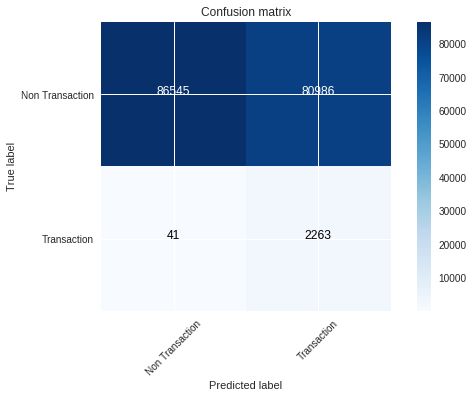

***********************
Roc Curve:
***********************


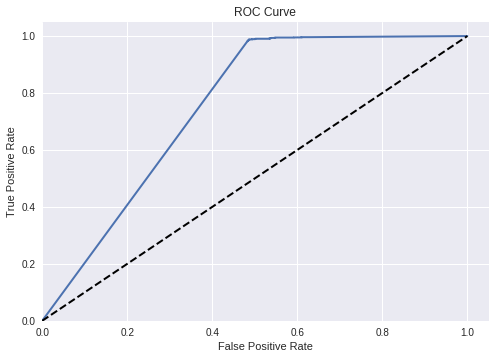

***********************
Precision Recall Curve:
***********************


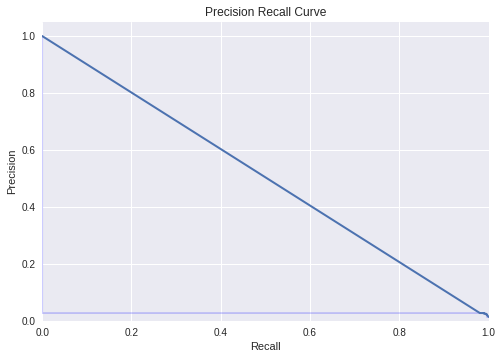

CPU times: user 4.39 s, sys: 619 ms, total: 5.01 s
Wall time: 4.32 s


In [0]:
%%time
# Fit and Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_scores_NB = model.predict_proba(X_test)[:,1]

# Show results
classes=['Non Transaction', 'Transaction']
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_NB, classes)

In [0]:
filename = 'finalized_model_nb.sav'

pickle.dump(model, open(filename, 'wb'))

In [0]:
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('finalized_model_nb.sav')
file.Upload()

### Random Forest

In [0]:
model = Pipeline(
    steps= [
      ('preprocess', preprocess), 
      ('clf_RF', RandomForestClassifier())
    ])

In [0]:
%%time
param_grid = {
            'clf_RF__n_estimators': [100],
            'clf_RF__max_features': [2],
            'clf_RF__min_samples_leaf': [2],
            'clf_RF__min_samples_split': [2]
            }


clf_RF_grid_search = GridSearchCV(estimator = model, param_grid = param_grid , scoring = 'recall', n_jobs = -1)
clf_RF_grid_search.fit(X_train, y_train)

print ('Best Params:', clf_RF_grid_search.best_params_)
print ('Best Recall:', clf_RF_grid_search.best_score_)

In [0]:
filename = 'finalized_model_rf.sav'

pickle.dump(clf_RF_grid_search, open(filename, 'wb'))

In [0]:
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('finalized_model_rf.sav')
file.Upload()

In [0]:
model = Pipeline(
    steps= [
      ('preprocess', preprocess), 
      ('clf_RF', RandomForestClassifier())
    ])

In [0]:
%%time
param_grid = {
            'clf_RF__n_estimators': [100],
            'clf_RF__max_features': [2],
            'clf_RF__min_samples_leaf': [2],
            'clf_RF__min_samples_split': [2]
            }


clf_RF_grid_search = GridSearchCV(estimator = model, param_grid = param_grid , scoring = 'recall', n_jobs = -1)
clf_RF_grid_search.fit(X_train, y_train)

print ('Best Params:', clf_RF_grid_search.best_params_)
print ('Best Recall:', clf_RF_grid_search.best_score_)

In [0]:
filename = 'finalized_model_rf.sav'

pickle.dump(clf_RF_grid_search, open(filename, 'wb'))

In [0]:
# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('finalized_model_rf.sav')
file.Upload()

### Save Training and Test Files


In [0]:
%%time
X_train.to_csv("X_train.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('X_train.csv')
file.Upload()

X_test.to_csv("X_test.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('X_test.csv')
file.Upload()

y_train.to_csv("y_train.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('y_train.csv')
file.Upload()

y_test.to_csv("y_test.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('y_test.csv')
file.Upload()

X_train_transformed.to_csv("X_train_transformed.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('X_train_transformed.csv')
file.Upload()

X_test_transformed.to_csv("X_test_transformed.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1z8scY025WNyT_3p-1B4sjz_aidLPi1ht'}]})
file.SetContentFile('X_test_transformed.csv')
file.Upload()

## Recupera resultado Modelo

### Recupera Bases Teste e Validação

In [23]:
%%time
X_test = pd.read_csv('gdrive/My Drive/Colab Notebooks/Propension/X_test.csv')
y_test = pd.read_csv('gdrive/My Drive/Colab Notebooks/Propension/y_test.csv')
X_train = pd.read_csv('gdrive/My Drive/Colab Notebooks/Propension/X_train.csv')
y_train = pd.read_csv('gdrive/My Drive/Colab Notebooks/Propension/y_train.csv')

CPU times: user 1.24 s, sys: 65.5 ms, total: 1.3 s
Wall time: 2.78 s


### Helper Methods

In [0]:
def get_column_names_from_ColumnTransformer(column_transformer):
    col_name = []
    header_list = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        header_list.append(raw_col_name)
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray):
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names
        elif isinstance(names,str):
            col_name.append(names)
    return col_name, header_list

In [0]:
#feature importance plot
def plot_feature_importance(features, columns):
    tmp = pd.DataFrame({'Feature': columns, 'Feature importance': features})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (15,8))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

### Logistic Regression

In [0]:
downloaded = drive.CreateFile({'id': '1qmlOPc6YG1B48m0OxIvQFndvyQq4AW87'})
downloaded.GetContentFile('finalized_model_logistic.sav')

In [0]:
loaded_model = pickle.load(open("finalized_model_logistic.sav", 'rb'))
result = loaded_model.score(X_test, y_test)

In [0]:
# Predict
y_pred = loaded_model.predict(X_test)
y_scores_LR = loaded_model.predict_proba(X_test)[:,1]

# Show results
classes=['Non Transaction', 'Transaction']
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_LR, classes)

How to get columns from ColumnTransformer: https://github.com/scikit-learn/scikit-learn/issues/12525

Como acessar coef e intercept de um pipeline: https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [0]:
print ('Best Params:', loaded_model.best_params_)
print ('Best Estimator:', loaded_model.best_estimator_)
print ('Best Recall:', loaded_model.best_score_)

classifier = loaded_model.best_estimator_.named_steps['logisticregression']
classifier.coef_[0]
classifier.intercept_

columnsTransform = loaded_model.best_estimator_.named_steps['preprocess']
columns_name, header_list = get_column_names_from_ColumnTransformer(columnsTransform)

In [0]:
plot_feature_importance(classifier.coef_[0], columns_name)
weights = pd.DataFrame(
    {'columns_name': columns_name, 
     'weights': classifier.coef_[0]
    }).sort_values(by=['weights'], ascending=False, inplace=False)

### KNN (erro Pickle)

In [0]:
downloaded = drive.CreateFile({'id': '1zqpFkUunDmmG4VbFoJb3LKvXmpQcpSkk'})
downloaded.GetContentFile('finalized_model_knn.sav')

In [17]:
loaded_model_knn = pickle.load(open("finalized_model_knn.sav", 'rb'))
result = loaded_model_knn.score(X_test, y_test)

UnpicklingError: ignored

In [0]:
# Predict
y_pred = loaded_model_knn.predict(X_test)
y_scores_LR = loaded_model_knn.predict_proba(X_test)[:,1]

# Show results
classes=['Non Transaction', 'Transaction']
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_LR, classes)

In [0]:
print ('Best Params:', loaded_model_knn.best_params_)
print ('Best Recall:', loaded_model_knn.best_score_)

classifier_knn = loaded_model_knn.best_estimator_.named_steps['logisticregression']
classifier_knn.coef_[0]
classifier_knn.intercept_

columnsTransform = loaded_model_knn.best_estimator_.named_steps['preprocess']
columns_name_knn, header_list_knn = get_column_names_from_ColumnTransformer(columnsTransform)

In [0]:
plot_feature_importance(classifier_knn.coef_[0], columns_name_knn)
weights = pd.DataFrame(
    {'columns_name': columns_name_knn, 
     'weights': classifier_knn.coef_[0]
    }).sort_values(by=['weights'], ascending=False, inplace=False)

###Lightgbm

In [0]:
downloaded = drive.CreateFile({'id': '1OiAAlkR08ORO7OYTuIjU0mWP4pUDwiW1'})
downloaded.GetContentFile('finalized_model_lgbm.sav')

In [0]:
loaded_model_lgbm = pickle.load(open("finalized_model_lgbm.sav", 'rb'))
result = loaded_model_lgbm.score(X_test, y_test)

AttributeError: ignored

In [0]:
print('Starting predicting...')
y_pred_lightgbm = loaded_model_lgbm.predict(X_test_transformed, num_iteration=gbm.best_iteration)

# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(loaded_model_lgbm.feature_importance()))

# Predictions binary
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)
stats.describe(y_pred)

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_pred_lightgbm, classes)

### Naive Bayes

In [0]:
downloaded = drive.CreateFile({'id': '1AI2DCy0BpCCwS75KqE8nFChSoXPBclFl'})
downloaded.GetContentFile('finalized_model_nb.sav')

In [0]:
loaded_model = pickle.load(open("finalized_model_nb.sav", 'rb'))
result = loaded_model.score(X_test, y_test)

In [0]:
# Predict
y_pred = loaded_model.predict(X_test)
y_scores_NB = loaded_model.predict_proba(X_test)[:,1]

# Show results
classes=['Non Transaction', 'Transaction']
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_NB, classes)

### Random Forest

In [0]:
downloaded = drive.CreateFile({'id': '1WB-I4gvcKjSkhwu_YHsJmggD-JmYRWT8'})
downloaded.GetContentFile('finalized_model_rf.sav')

In [0]:
loaded_model = pickle.load(open("finalized_model_rf.sav", 'rb'))
result = loaded_model.score(X_test, y_test)

In [0]:
# Predict
y_pred = loaded_model.predict(X_test)
y_scores_RF = loaded_model.predict_proba(X_test)[:,1]

# Show results
classes=['Non Transaction', 'Transaction']
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_RF, classes)

### Soft Voting Classifier

In [0]:
# Load Logistic Regression
downloaded = drive.CreateFile({'id': '1qmlOPc6YG1B48m0OxIvQFndvyQq4AW87'})
downloaded.GetContentFile('finalized_model_logistic.sav')
clf_LR_grid_search = pickle.load(open("finalized_model_logistic.sav", 'rb'))

In [0]:
# Load Naive Bayes
downloaded = drive.CreateFile({'id': '1AI2DCy0BpCCwS75KqE8nFChSoXPBclFl'})
downloaded.GetContentFile('finalized_model_nb.sav')
clf_NB = pickle.load(open("finalized_model_nb.sav", 'rb'))

In [0]:
# Load Random Forest
downloaded = drive.CreateFile({'id': '1WB-I4gvcKjSkhwu_YHsJmggD-JmYRWT8'})
downloaded.GetContentFile('finalized_model_rf.sav')
clf_RF_grid_search = pickle.load(open("finalized_model_rf.sav", 'rb'))

In [0]:
voting_clf = VotingClassifier (
        estimators = [('lg', clf_LR_grid_search), ('rf', clf_RF_grid_search)], voting='soft')#('nb', clf_NB), ('rf', clf_RF_grid_search)], voting='soft')

In [0]:
voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
y_scores_VotingClassifier = voting_clf.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_VotingClassifier, classes)

### Stacking Classifier

In [0]:
# Load Logistic Regression
downloaded = drive.CreateFile({'id': '1qmlOPc6YG1B48m0OxIvQFndvyQq4AW87'})
downloaded.GetContentFile('finalized_model_logistic.sav')
clf_LR_grid_search = pickle.load(open("finalized_model_logistic.sav", 'rb'))

In [0]:
# Load Naive Bayes
downloaded = drive.CreateFile({'id': '1AI2DCy0BpCCwS75KqE8nFChSoXPBclFl'})
downloaded.GetContentFile('finalized_model_nb.sav')
clf_NB = pickle.load(open("finalized_model_nb.sav", 'rb'))

In [0]:
# Load Random Forest
downloaded = drive.CreateFile({'id': '1WB-I4gvcKjSkhwu_YHsJmggD-JmYRWT8'})
downloaded.GetContentFile('finalized_model_rf.sav')
clf_RF_grid_search = pickle.load(open("finalized_model_rf.sav", 'rb'))

In [0]:
stacking_clf = StackingClassifier(classifiers=[clf_LR_grid_search, clf_NB, clf_RF_grid_search],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=LogisticRegression())

In [0]:
stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)
y_scores_StackingClassifier = stacking_clf.predict_proba(X_test)[:,1]

# Show results
HelperClass.show_full_classification_report(y_test, y_pred, y_scores_StackingClassifier, classes)